# Introduction

This notebook is the final project of the data science course in the College of Management.
Written By: 
* Itay Gabbay
* Matan Perelmuter
* Amit Ben Ami
* Danielle Zror
* Gal Wurmbrand.

## Data
The Hotels dataset is a collection of snapshots of prices from several NYC Hotels, taken between 2015-2016

In [146]:
# Imports

# pandas
import pandas as pd
import numpy as np
from datetime import date


hotels_df = pd.read_csv("./input/hotels_data.csv")

hotels_df.head()

# Converting to date
hotels_df["Snapshot Date"] = pd.to_datetime(hotels_df["Snapshot Date"])#, format='%m-/%d-/%y %-H:%M')
hotels_df["Checkin Date"] = pd.to_datetime(hotels_df["Checkin Date"])#, format='%m-/%d-/%y %H-:%M')

hotels_df["DayDiff"] = (hotels_df["Checkin Date"].sub(hotels_df["Snapshot Date"], axis=0)).apply(lambda x: x.days)
hotels_df["WeekDay"] = hotels_df["Checkin Date"].apply(lambda x: x.strftime('%a'))
hotels_df["DiscountDiff"] = hotels_df["Original Price"] - hotels_df["Discount Price"]
hotels_df["DiscountPerc"] = (hotels_df["DiscountDiff"]/hotels_df["Original Price"]) * 100



##### Let's explore our converted dataset, and save it to a new csv file

In [147]:
print (hotels_df.describe())

print(hotels_df.head())

hotels_df.to_csv("./input/Hotels_data_Changed.csv", encoding = "utf8")

         Snapshot ID      Days  Original Price  Discount Price  Discount Code  \
count  187848.000000  187848.0   187848.000000   187848.000000  187848.000000   
mean      351.643451       5.0     1825.742143     1673.172283       2.434186   
std      1007.348927       0.0     1042.355712      983.618013       1.005191   
min         1.000000       5.0      289.000000      260.000000       1.000000   
25%       150.000000       5.0     1160.000000     1035.000000       2.000000   
50%       439.000000       5.0     1599.000000     1475.000000       2.000000   
75%       506.000000       5.0     2160.000000     1963.250000       3.000000   
max    417419.000000       5.0    29975.000000    28675.000000       4.000000   

       Available Rooms    Hotel Stars        DayDiff   DiscountDiff  \
count    187848.000000  187848.000000  187848.000000  187848.000000   
mean         14.588561       3.905823      17.465685     152.569860   
std          41.575482       0.846496      10.040225     

### Data Exploration

We need to remember that we want to predict the discount code that will give us the max discount.

Now, we investigate the correlation between the different features, and the required predicted column - the discount code

In [148]:
# Here will be data exploration
corr_df = hotels_df
corr_df["Hotel ID"] = corr_df["Hotel Name"].factorize()[0]
corr_df["Checkin Date Ordinal"] = pd.to_datetime(corr_df["Checkin Date"]).apply(lambda x: x.toordinal())
corr_df["Snapshot Date Ordinal"] = pd.to_datetime(corr_df["Snapshot Date"]).apply(lambda x: x.toordinal())

corr_df["WeekDayNum"] = corr_df["WeekDay"].factorize()[0]
print (corr_df.corr()["DiscountPerc"])

Snapshot ID              0.026398
Days                          NaN
Original Price          -0.151366
Discount Price          -0.258325
Discount Code           -0.036223
Available Rooms         -0.092789
Hotel Stars             -0.090960
DayDiff                 -0.018199
DiscountDiff             0.672048
DiscountPerc             1.000000
Hotel ID                -0.076962
Checkin Date Ordinal     0.166905
Snapshot Date Ordinal    0.172947
WeekDayNum              -0.054560
Name: DiscountPerc, dtype: float64


As we can see, we don't have strong linear correlation between the features to the discount percentage.
Thus, The relation is not linear.

We'll try to find a correlation between the maximum discount for each Week day, Snapshot Date, Check in Date, The Difference between Snapshot date and Checkin in days, and the hotel name

In [149]:
hotels_formatted = pd.read_csv("./input/Hotels_data_Changed.csv", encoding = "utf8")

maxDiscount = hotels_formatted.groupby(["WeekDay", "Snapshot Date", "Checkin Date", "DayDiff", "Hotel Name"])["DiscountPerc"].max()

maxDiscount = maxDiscount.to_frame().reset_index()
mergedResult = pd.merge(maxDiscount, hotels_formatted, left_on=['WeekDay', "Snapshot Date", "Checkin Date", "DayDiff", "Hotel Name", "DiscountPerc"],
                        right_on=['WeekDay', "Snapshot Date", "Checkin Date", "DayDiff", "Hotel Name", "DiscountPerc"])

mergedResult[['WeekDay', "Snapshot Date", "Checkin Date", "DayDiff", "Hotel Name", "Discount Code"]].to_csv("./input/max_discounts.csv", encoding="utf8")

In [150]:
# Here will be data exploration
corr_df = mergedResult
corr_df["Hotel ID"] = corr_df["Hotel Name"].factorize()[0]
corr_df["Checkin Date Ordinal"] = pd.to_datetime(corr_df["Checkin Date"]).apply(lambda x: x.toordinal())
corr_df["Snapshot Date Ordinal"] = pd.to_datetime(corr_df["Snapshot Date"]).apply(lambda x: x.toordinal())

corr_df["WeekDayNum"] = corr_df["WeekDay"].factorize()[0]
print (corr_df.corr()["DiscountPerc"])

DayDiff                 -0.014849
DiscountPerc             1.000000
Unnamed: 0               0.146411
Snapshot ID              0.084118
Days                          NaN
Original Price          -0.114407
Discount Price          -0.233243
Discount Code           -0.027188
Available Rooms         -0.082800
Hotel Stars             -0.075999
DiscountDiff             0.680349
Hotel ID                 0.017336
Checkin Date Ordinal     0.169321
Snapshot Date Ordinal    0.174770
WeekDayNum               0.057380
Name: DiscountPerc, dtype: float64


In [155]:
from sklearn import metrics
from sklearn.cross_validation import train_test_split

raw_data = pd.read_csv("./input/max_discounts.csv")
hotels = pd.get_dummies(raw_data["Hotel Name"]).add_prefix('Hotel_Name_')
raw_data = raw_data.join(hotels)
raw_data = raw_data.drop('Hotel Name', axis=1)
raw_data["Snapshot year"] = pd.to_datetime(raw_data["Snapshot Date"]).dt.year.factorize()[0]
raw_data["Snapshot month"] = pd.to_datetime(raw_data["Snapshot Date"]).dt.month
raw_data["Snapshot day"] = pd.to_datetime(raw_data["Snapshot Date"]).dt.day
raw_data["Checkin year"] = pd.to_datetime(raw_data["Checkin Date"]).dt.year.factorize()[0]
raw_data["Checkin month"] = pd.to_datetime(raw_data["Checkin Date"]).dt.month
raw_data["Checkin day"] = pd.to_datetime(raw_data["Checkin Date"]).dt.day

raw_data["Weekday ID"] = raw_data["WeekDay"].factorize()[0]
weekdays = pd.get_dummies(raw_data["Weekday ID"]).add_prefix('Weekday_')
raw_data = raw_data.join(weekdays)
raw_data = raw_data.drop('Weekday ID', axis=1)
# raw_data.to_csv('raw.csv', index = False)
X = raw_data.drop(["Snapshot Date", "Checkin Date", "WeekDay", "Discount Code"], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, raw_data[["Discount Code"]])

In [156]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

treeModel = DecisionTreeClassifier()
treeModel.fit(X_train, Y_train)

treePredicted = treeModel.predict(X_test)
treeExpected = Y_test

print (metrics.accuracy_score(treeExpected, treePredicted))

0.708823630905


In [157]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, Y_train.values.ravel())

print (model.score(X_test, Y_test))

0.338762552193


In [93]:
# Clustring

ordered_hotels = pd.read_csv("./input/Hotels_data_Changed.csv", encoding = "utf8")
hotel_count = ordered_hotels.groupby("Hotel Name").size().reset_index(name="counts")
hotel_count = hotel_count.sort_values("counts", ascending=False).head(150)[["Hotel Name"]]
ordered_hotels = pd.merge(left = hotel_count, right=ordered_hotels,left_on="Hotel Name", right_on="Hotel Name")
date_count = ordered_hotels.groupby("Checkin Date").size().reset_index(name="counts")
date_count = date_count.sort_values("counts", ascending=False).head(40)[["Checkin Date"]]
ordered_hotels = pd.merge(left=date_count, right=ordered_hotels, left_on="Checkin Date", right_on="Checkin Date")

# print(test.sort_values("Discount Price", ascending=False))

from sklearn import preprocessing

#Creating the clustered data frame
min_price = ordered_hotels.groupby(["Checkin Date", "Hotel Name", "Discount Code"])["Discount Price"].min()

min_price = min_price.to_frame().reset_index()

# Normalization
def normalize(x):
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 100))
    return pd.Series(min_max_scaler.fit_transform(x.values), index=x.index)

hotelPrices = min_price.groupby("Hotel Name")["Discount Price"]
# print (min_price.loc[min_price["Hotel Name"] == "Hampton Inn Times Square North"].sort_values("Discount Price", ascending=False))
hotelPrices = hotelPrices.apply(normalize)
min_price["Discount Price"] = hotelPrices
# print (min_price.loc[min_price["Hotel Name"] == "Hampton Inn Times Square North"].sort_values("Discount Price", ascending=False))
pivot = pd.pivot_table(min_price, values='Discount Price', columns=["Checkin Date", "Discount Code"], index=["Hotel Name"])
pivot = pivot.fillna(-1)
pivot.to_csv("./input/datatocluster.csv", encoding = "utf8")

c:\users\itay gabbay\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
c:\users\itay gabbay\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\users\itay gabbay\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sam

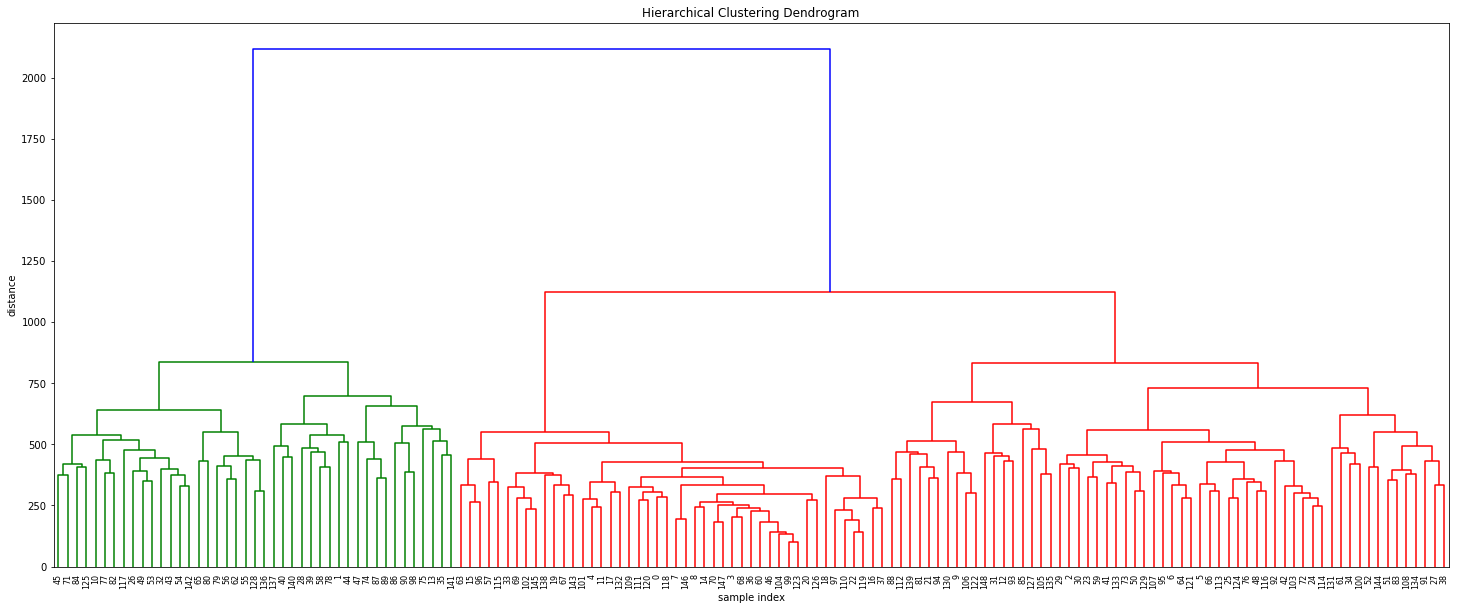

In [94]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

Z = linkage(pivot, 'ward')

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    truncate_mode='lastp',  # show only the last p merged clusters
    p=150,  # show only the last p merged clusters
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()
